<a href="https://colab.research.google.com/github/alexshtf/alexshtf.github.io/blob/eigenspeed/assets/spectrum_power_speed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib

matplotlib.rcParams['figure.dpi'] = 120

In [2]:
import torch
print(torch.__version__)

2.9.0+cu126


# NumPy experiments

In [5]:
mats = torch.randn(500, 100, 100)

In [9]:
%%time
torch.linalg.eigvalsh(mats).sum()

CPU times: user 226 ms, sys: 6.96 ms, total: 233 ms
Wall time: 188 ms


tensor(56.6666)

In [7]:
import numpy as np

numpy_mats = mats.numpy()

In [8]:
%%time
np.linalg.eigvalsh(numpy_mats).sum()

CPU times: user 942 ms, sys: 7.07 ms, total: 949 ms
Wall time: 337 ms


np.float32(56.665924)

# CuPy experiments

In [26]:
mats = torch.randn(500, 100, 100, device='cuda')
torch.linalg.eigvalsh(mats).sum()

tensor(-557.2836, device='cuda:0')

In [27]:
%%time
torch.linalg.eigvalsh(mats).sum()

CPU times: user 794 ms, sys: 0 ns, total: 794 ms
Wall time: 794 ms


tensor(-557.2836, device='cuda:0')

In [28]:
from torch.utils import dlpack as torch_dlpack

x = torch.tensor([1, -2, 3], device='cuda')
torch_dlpack.to_dlpack(x)

<capsule object "dltensor" at 0x7b4d2b5a7de0>

In [29]:
import cupy as cp

cp.from_dlpack(torch_dlpack.to_dlpack(x))

array([ 1, -2,  3])

In [30]:
cupy_mats = cp.from_dlpack(torch_dlpack.to_dlpack(mats))
cp.linalg.eigvalsh(cupy_mats).sum()

array(-557.284, dtype=float32)

In [31]:
%%time
cp.linalg.eigvalsh(cupy_mats).sum()

CPU times: user 1.58 ms, sys: 0 ns, total: 1.58 ms
Wall time: 1.37 ms


array(-557.284, dtype=float32)

In [37]:
%%time
eigvals_cupy = cp.linalg.eigvalsh(cupy_mats)
torch_dlpack.from_dlpack(eigvals_cupy).sum()

CPU times: user 1.66 ms, sys: 0 ns, total: 1.66 ms
Wall time: 1.31 ms


tensor(-557.2838, device='cuda:0')

# Eigenvalue gradients

In [15]:
mat = torch.linspace(-5, 5, 25).reshape(5, 5)
w, Q = torch.linalg.eigh(mat)
i = 2
grad_mat = Q[:, i].view(-1, 1) @ Q[:, i].view(1, -1)
grad_mat

tensor([[ 0.1389, -0.2269, -0.0168,  0.2359, -0.1102],
        [-0.2269,  0.3708,  0.0274, -0.3855,  0.1801],
        [-0.0168,  0.0274,  0.0020, -0.0285,  0.0133],
        [ 0.2359, -0.3855, -0.0285,  0.4008, -0.1873],
        [-0.1102,  0.1801,  0.0133, -0.1873,  0.0875]])

In [16]:
mat_param = torch.nn.Parameter(torch.linspace(-5, 5, 25).reshape(5, 5))
w = torch.linalg.eigvalsh(mat_param)
w[i].backward()
mat_param.grad

tensor([[ 0.1389, -0.2269, -0.0168,  0.2359, -0.1102],
        [-0.2269,  0.3708,  0.0274, -0.3855,  0.1801],
        [-0.0168,  0.0274,  0.0020, -0.0285,  0.0133],
        [ 0.2359, -0.3855, -0.0285,  0.4008, -0.1873],
        [-0.1102,  0.1801,  0.0133, -0.1873,  0.0875]])

# The AutoGrad function

In [6]:
import torch
import cupy as cp
from torch.utils import dlpack as torch_dlpack

In [17]:
def _torch_to_cupy(x: torch.Tensor):
    """ Zero-copy via DLPack for CUDA """
    return cp.from_dlpack(torch_dlpack.to_dlpack(x))

def _cupy_to_torch(x_cupy):
    """ Zero-copy via DLPack for CUDA """
    return torch_dlpack.from_dlpack(x_cupy)


class CuPyKthEigval(torch.autograd.Function):
    @staticmethod
    def forward(ctx, A: torch.Tensor, k: int, lower: bool = True):
        need_grad = ctx.needs_input_grad[0]
        A_ = A if A.is_contiguous() else A.contiguous()
        uplo = "L" if lower else "U"
        A_cp = _torch_to_cupy(A.detach())

        if need_grad:
            # for training
            ws_cp, Qs_cp = cp.linalg.eigh(A_cp, UPLO=uplo)
            ws = _cupy_to_torch(ws_cp).to(dtype=A.dtype, device=A.device)
            Qs = _cupy_to_torch(Qs_cp).to(dtype=A.dtype, device=A.device)
            ctx.save_for_backward(Qs[..., k].unsqueeze(-1)) # k-th eigenvector
        else:
            # for inference
            ws_cp = cp.linalg.eigvalsh(A_cp, UPLO=uplo)
            ws = _cupy_to_torch(ws_cp).to(dtype=A.dtype, device=A.device)

        return ws[..., k] # k-th eigenvalue

    @staticmethod
    def backward(ctx, grad_w: torch.Tensor):
        (Q,) = ctx.saved_tensors  # (..., n, 1)
        grad_w = grad_w.to(dtype=Q.dtype)
        grad_A = (Q * grad_w[..., None, None]) @ Q.transpose(-1, -2)
        return grad_A, None, None  # no grad for `k` and `lower`


In [18]:
mat_param = torch.nn.Parameter(torch.linspace(-5, 5, 25, device='cuda').reshape(5, 5))
w = CuPyKthEigval.apply(mat_param, 2)
w.backward()
mat_param.grad

tensor([[ 0.1389, -0.2269, -0.0168,  0.2359, -0.1102],
        [-0.2269,  0.3708,  0.0274, -0.3855,  0.1801],
        [-0.0168,  0.0274,  0.0020, -0.0285,  0.0133],
        [ 0.2359, -0.3855, -0.0285,  0.4008, -0.1873],
        [-0.1102,  0.1801,  0.0133, -0.1873,  0.0875]], device='cuda:0')

In [ ]:
def faster_kth_eigvalh(
        A: torch.Tensor, k: int,  *, lower: bool = True
    ) -> torch.Tensor:
    if A.is_cuda:
        return CuPyKthEigval.apply(A, k, lower)
    else:
        return torch.linalg.eigvalsh(A, lower=lower)[..., k]


# Faster model

In [19]:
import math
from torch import nn

class Nondecreasing(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        init = torch.linspace(-1, 1, dim)
        self.start = nn.Parameter(init[:1])
        self.increments = nn.Parameter(init.diff().expm1().log())

    def forward(self):
        return torch.cat([
            self.start,
            self.start + nn.functional.softplus(self.increments).cumsum(dim=0)
        ])

In [20]:
class MultivariateSpectral(nn.Module):
    def __init__(self, *, num_features: int, dim: int, eigval_idx: int):
        super().__init__()
        self.eigval_idx = eigval_idx
        self.mu = Nondecreasing(dim)
        self.A = nn.Parameter(
            torch.randn(num_features, dim, dim) / (math.sqrt(dim) * num_features)
        )

    def forward(self, x):
        # batches of sum of x[i] * A[i]
        nf, dim = self.A.shape[:2]
        feature_mat = (x @ self.A.view(nf, dim * dim)).view(-1, dim, dim)

        # diag(mu) replicated per batch
        bias_mat = torch.diagflat(self.mu()).expand_as(feature_mat)

        # batched eigenvalue computation
        return self._compute_eigval(bias_mat + feature_mat)

    def _compute_eigval(self, mat):
        return faster_kth_eigvalh(mat, self.eigval_idx)

In [21]:
class MultivariateSpectralTorch(MultivariateSpectral):
    def _compute_eigval(self, mat):
        return torch.linalg.eigvalsh(mat)[..., self.eigval_idx]

# California housing demo

## Prepartion - from previous post

In [22]:
import pandas as pd

train_df = pd.read_csv('sample_data/california_housing_train.csv')
test_df = pd.read_csv('sample_data/california_housing_test.csv')

In [23]:
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error

xgb = XGBRegressor(random_state=42)
xgb.fit(
    train_df.drop('median_house_value', axis=1),
    train_df['median_house_value']
)

pred = xgb.predict(test_df.drop('median_house_value', axis=1))
xgboost_rmse = root_mean_squared_error(test_df['median_house_value'], pred)
print(f'XGBoost test RMSE = {xgboost_rmse:.2f}')

XGBoost test RMSE = 48023.99


In [24]:
import numpy as np

skewed_columns = ['total_rooms', 'total_bedrooms', 'population', 'households']
train_df[skewed_columns] = train_df[skewed_columns].apply(np.log)
test_df[skewed_columns] = test_df[skewed_columns].apply(np.log)

In [25]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().set_output(transform='pandas')
train_scaled = scaler.fit_transform(train_df)
test_scaled = scaler.transform(test_df)

label_scale = float(scaler.scale_[-1])

In [26]:
from torch import as_tensor

def to_tensors(df):
    target = 'median_house_value'
    return (
        as_tensor(df.drop(target, axis=1).values, dtype=torch.float32),
        as_tensor(df[target].values, dtype=torch.float32)
    )

X_train, y_train = to_tensors(train_scaled)
X_test, y_test = to_tensors(test_scaled)

num_features = X_train.shape[1]
feature_names = train_df.columns[:num_features].tolist()
n_train = len(X_train)

## Training and plotting code - from previous post

In [27]:
device = 'cuda'

In [28]:
def train_epoch(
        device, net, optimizer, criterion, regularizer, X_batches, y_batches
    ):
    epoch_loss = torch.zeros(1).to(device)
    for x, y in zip(X_batches, y_batches):
        optimizer.zero_grad()
        loss = criterion(net(x), y)
        cost = loss + regularizer(net)
        cost.backward()

        with torch.no_grad():
            epoch_loss += loss * x.shape[0]
        optimizer.step()
    return (epoch_loss / n_train).cpu().item()


def train_model_stream(
        net, criterion, *, n_epochs=200, batch_size=10, lr=1e-4,
        regularizer=None
    ):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    regularizer = regularizer or (lambda model: 0.)

    net.to(device)
    X_train_batches = X_train.to(device).split(batch_size)
    y_train_batches = y_train.to(device).split(batch_size)
    X_test_device = X_test.to(device)
    y_test_device = y_test.to(device)

    optimizer = torch.optim.AdamW(
        net.parameters(), lr=lr
    )
    for epoch in range(1, 1 + n_epochs):
        train_loss = train_epoch(
            device, net, optimizer, criterion, regularizer,
            X_train_batches, y_train_batches
        )

        with torch.no_grad():
            test_loss = criterion(net(X_test_device), y_test_device)
            test_loss = test_loss.cpu().item()

        yield {
            'step': epoch,
            'model': net,
            'train_error': math.sqrt(train_loss) * label_scale,
            'test_error': math.sqrt(test_loss) * label_scale,
        }

In [29]:
import torch.linalg as tla

def add_spectral_norms(stream):
    for event in stream:
        model = event['model']
        with torch.no_grad():
            matrices_sym = \
                model.A.tril() + model.A.tril(diagonal=-1).transpose(-1, -2)
            norms = tla.matrix_norm(matrices_sym, ord=2)
            norms = norms.ravel().cpu().tolist()

        yield {
            'step': event['step'],
            'train_error': event['train_error'],
            'test_error': event['test_error'],
        } | {
            f'norm_{feature_name}': norm
            for feature_name, norm in zip(feature_names, norms)
        }

In [30]:
def training_stream(model, n_epochs, **train_kwargs):
    criterion = nn.MSELoss()
    return add_spectral_norms(train_model_stream(
        model, criterion, n_epochs=n_epochs, **train_kwargs
    ))

In [31]:
%%time
model = MultivariateSpectralTorch(num_features=num_features, dim=45, eigval_idx=22)
for event in training_stream(model, n_epochs=5):
    print('tick')

tick
tick
tick
tick
tick
CPU times: user 1min 16s, sys: 466 ms, total: 1min 16s
Wall time: 1min 16s


In [32]:
%%time
model = MultivariateSpectral(num_features=num_features, dim=45, eigval_idx=22)
for event in training_stream(model, n_epochs=5):
    print('tick')

tick
tick
tick
tick
tick
CPU times: user 15.7 s, sys: 205 ms, total: 15.9 s
Wall time: 16.1 s


In [33]:
import matplotlib.pyplot as plt

def plot_progress(events, max_step):
    # create a plot with two axes - one for errors, one for norms
    fig, (err_ax, norm_ax) = plt.subplots(
        2, 1, figsize=(8, 8), layout='constrained'
    )

    # ceate empty line objects
    def plot_empty(ax, label):
        return ax.plot([], [], label=label)[0]

    line_dict = {
        'train_error': plot_empty(err_ax, 'train error'),
        'test_error': plot_empty(err_ax, 'test error'),
    } | {
        f'norm_{feature_name}': plot_empty(norm_ax, feature_name)
        for feature_name in feature_names
    }

    # setup axis properties
    err_ax.set_title("Error")
    norm_ax.set_title("Matrix norms")
    for ax in (err_ax, norm_ax):
        ax.set_xlabel("Step")
        ax.set_xlim(0, max_step)
        ax.grid(True)
        ax.legend()


    # display figure and obtain its handle
    h = display(fig, display_id=True)
    plt.close(fig)

    # iterate over events and update the plot
    min_test_error = float('inf')
    for event in events:
        step = event['step']
        min_test_error = min(min_test_error, event['test_error'])
        err_ax.set_title(f'Error (min test err = {min_test_error:.2f})')

        for key, line in line_dict.items():
            value = event[key]
            x, y = line.get_data(orig=True)
            line.set_data(np.append(x, step), np.append(y, value))

        for axs in (err_ax, norm_ax):
            axs.relim()
            axs.autoscale_view()

        fig.canvas.draw()
        h.update(fig)

## Training with various sizes

In [34]:
def live_plot_training(dim, n_epochs, **train_kwargs):
    model = MultivariateSpectral(
        num_features=num_features, dim=dim, eigval_idx=dim // 2
    )
    events = training_stream(model, n_epochs, **train_kwargs)
    plot_progress(
        events, max_step=n_epochs
    )

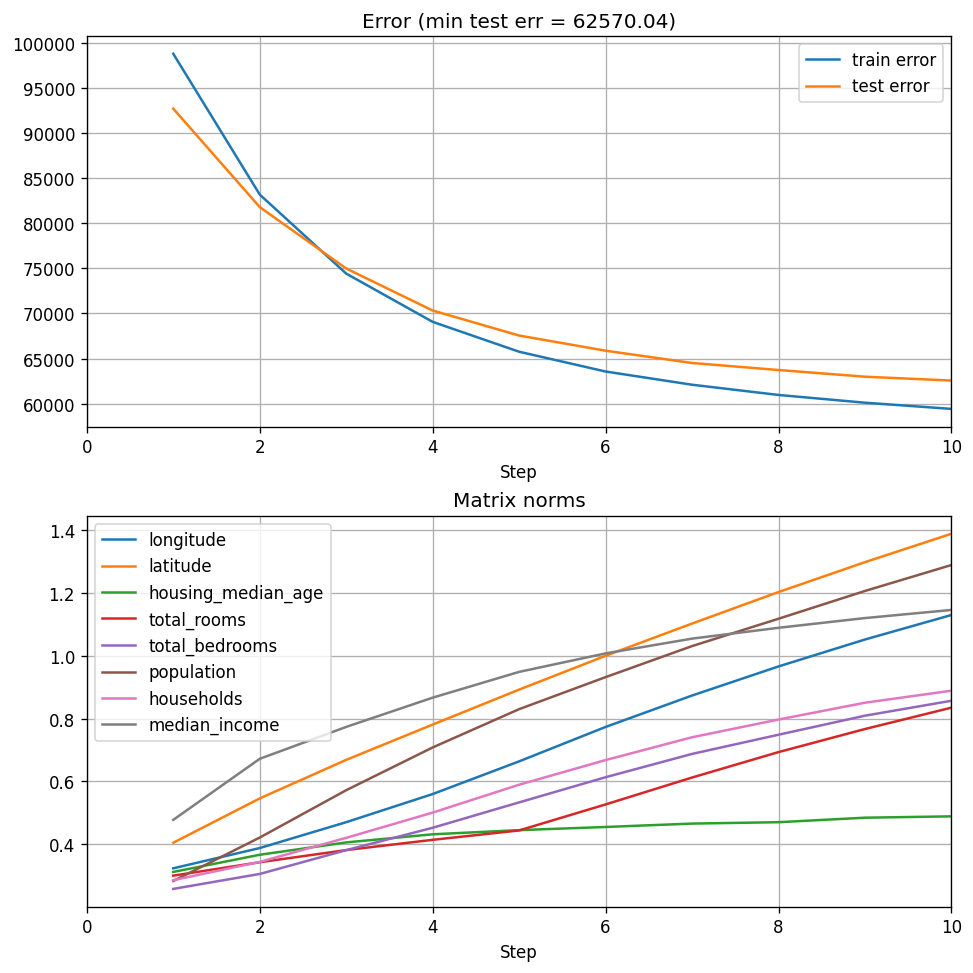

CPU times: user 37 s, sys: 498 ms, total: 37.5 s
Wall time: 37.7 s


In [35]:
%%time
live_plot_training(dim=45, n_epochs=10)

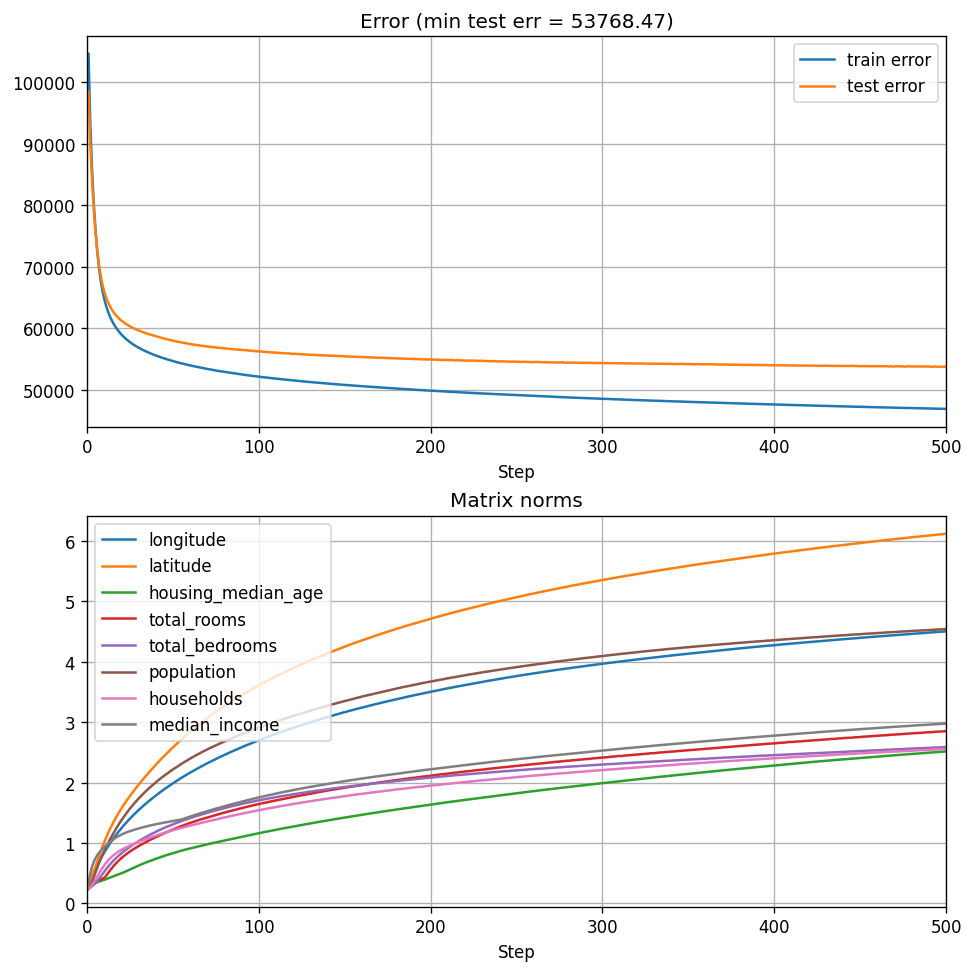

CPU times: user 30min 45s, sys: 23.7 s, total: 31min 8s
Wall time: 31min 23s


In [36]:
%%time
live_plot_training(dim=45, n_epochs=500, lr=5e-5)